In [1]:
from utils import saver
import os
from os.path import join, exists

import albumentations as albu
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.data import Dataset

import utils
from utils.transforms import get_augmentations, get_transforms

class CustomDataset(Dataset):

    def __init__(self, config, phase='train'):
        self.df = a
        self.phase = phase
        self.transforms = get_transforms(config)
        self.augmentations = get_augmentations(config) if 'train' in phase else None
        self.config = config

    def __len__(self):
        return len(self.df) * (self.config.dataset.repeat_dataset+1)

    def __getitem__(self, idx):
        """

        :param idx:
        :return: {..., bbox(4, 2): [upLeft, upRight, downLeft, downRight]}
        """
        idx %= len(self.df)
        img_name = self.df.loc[idx, 'Image Index']
        img_path = os.path.join(self.config.dataset.root[self.df.loc[idx,'Dataset']],
                                img_name)
        
        img_path = img_path.replace("IMG","png")
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bbox = np.array(eval(self.df.loc[idx, 'bbox']))

        resize_pair = albu.Compose([albu.Resize(self.config.dataset.img_size, self.config.dataset.img_size)],
                                   keypoint_params={'format': 'xy', "remove_invisible": False})
        augmented = resize_pair(image=image, keypoints=bbox)

        image = augmented['image']
        bbox = np.round(np.array(augmented['keypoints'])).astype(int)

        target = np.copy(image)
        target[bbox[0, 1]:bbox[2, 1], bbox[0, 0]:bbox[1, 0], :] = 0

        sample = {'image': target, 'target': image, 'bbox': bbox, 'img_name': img_name}

        if self.augmentations and 'train' in self.phase:
            augmented = self.augmentations(image=sample['image'], target=sample['target'], keypoints=sample['bbox'])
            if ((np.array(augmented['keypoints']).min() < 0) or
                    (np.array(augmented['keypoints']).max() > self.config.dataset.img_size)):
                print('Wrong augmentations')
            else:
                sample['image'] = augmented['image']
                sample['target'] = augmented['target']
                sample['bbox'] = np.array(augmented['keypoints'])

        if self.transforms:
            # Apply transform to numpy.ndarray which represents sample image
            transformed = self.transforms(image=sample['image'], target=sample['target'], keypoints=sample['bbox'])
            sample['image'] = transformed['image']
            sample['target'] = transformed['target']
            sample['bbox'] = torch.tensor(transformed['keypoints'])

        sample['image'] = sample['image'].float()
        sample['target'] = sample['target'].float()
        sample['bbox'] = sample['bbox'].float()
        return sample


In [2]:
config = saver.load_config_dump("configs/heatmap_augmentations_weightedloss_borders.yaml")
config.dataset.train['csv_path']= "playground/train.csv"
config.dataset.val['csv_path']= "playground/val.csv"
config.dataset.test['csv_path']= "playground/test.csv"

config.dataset.root['NIH'] = "/home/ailab_user/work/data/NIH/images"
config.dataset.augmentations = []
config.dataset.transforms
config.protocol = "ae"
config.dataset.img_size = 512

In [3]:
import torch
import importlib

from torch import nn

from utils.activations import get_activation
from utils.param_initialization import get_init_func
models_module = importlib.import_module('protocols.{}.models'.format(config.protocol))
model = getattr(models_module, config.model.name)()
model = nn.Sequential(model, get_activation(config))

path_to_weights = "/home/ailab_user/work/CancerAstro/playground/G_latest.pth"
state_dict = torch.load(path_to_weights)
if "module" in list(state_dict.keys())[0]:
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v
    state_dict = new_state_dict

model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
a = pd.read_csv(config.dataset["test"].csv_path)
a = a[a.Dataset != "JSRT"].reset_index()
ds = CustomDataset(config)

In [5]:
import matplotlib.pylab as plt
import numpy as np
%matplotlib qt
import time

f,a = plt.subplots()
i = 1

data = ds[i]
img = data['target']

pic = a.imshow(img[0])
pos = []
def onclick(event):
    global pos
    global i
    global img
    pos.append([event.xdata,event.ydata])
    data = ds[i]
    img = data['target']
    pic.set_data(img[0])
    if len(pos) == 2:
        #[upLeft, upRight, downLeft, downRight]}
        pos = np.array(pos)
        pos = [pos[0],(pos[1][0],pos[0][1]),(pos[0][0],pos[1][1]),pos[1]]
        #radius = 6
      #  pos = pos[0]
       # pos = [(pos[0]-radius,pos[1]-radius),(pos[0]+radius,pos[1]-radius),(pos[0]-radius,pos[1]+radius),(pos[0]+radius,pos[1]+radius)]
        bbox = np.round(np.array(pos)).astype(int)
        target = np.copy(img)
        target[:,bbox[0, 1]:bbox[2, 1], bbox[0, 0]:bbox[1, 0]] = 0
        output = model(torch.tensor(target).unsqueeze(0))
        pic.set_data(output[0][0].detach().numpy())
        f.canvas.draw()
        f.canvas.flush_events()
        pos = []
        
def onpress(event):
    global i
    if event.key == "x":
        i+=1
        data = ds[i]
        img = data['target']
        pic.set_data(img[0])
        f.canvas.draw()
        f.canvas.flush_events()
    if event.key == "z":
        i-=1
        data = ds[i]
        img = data['target']
        pic.set_data(img[0])
        f.canvas.draw()
        f.canvas.flush_events()


f.canvas.mpl_connect("key_press_event",onpress)
f.canvas.mpl_connect('button_press_event', onclick)
f.show()



/home/ailab_user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


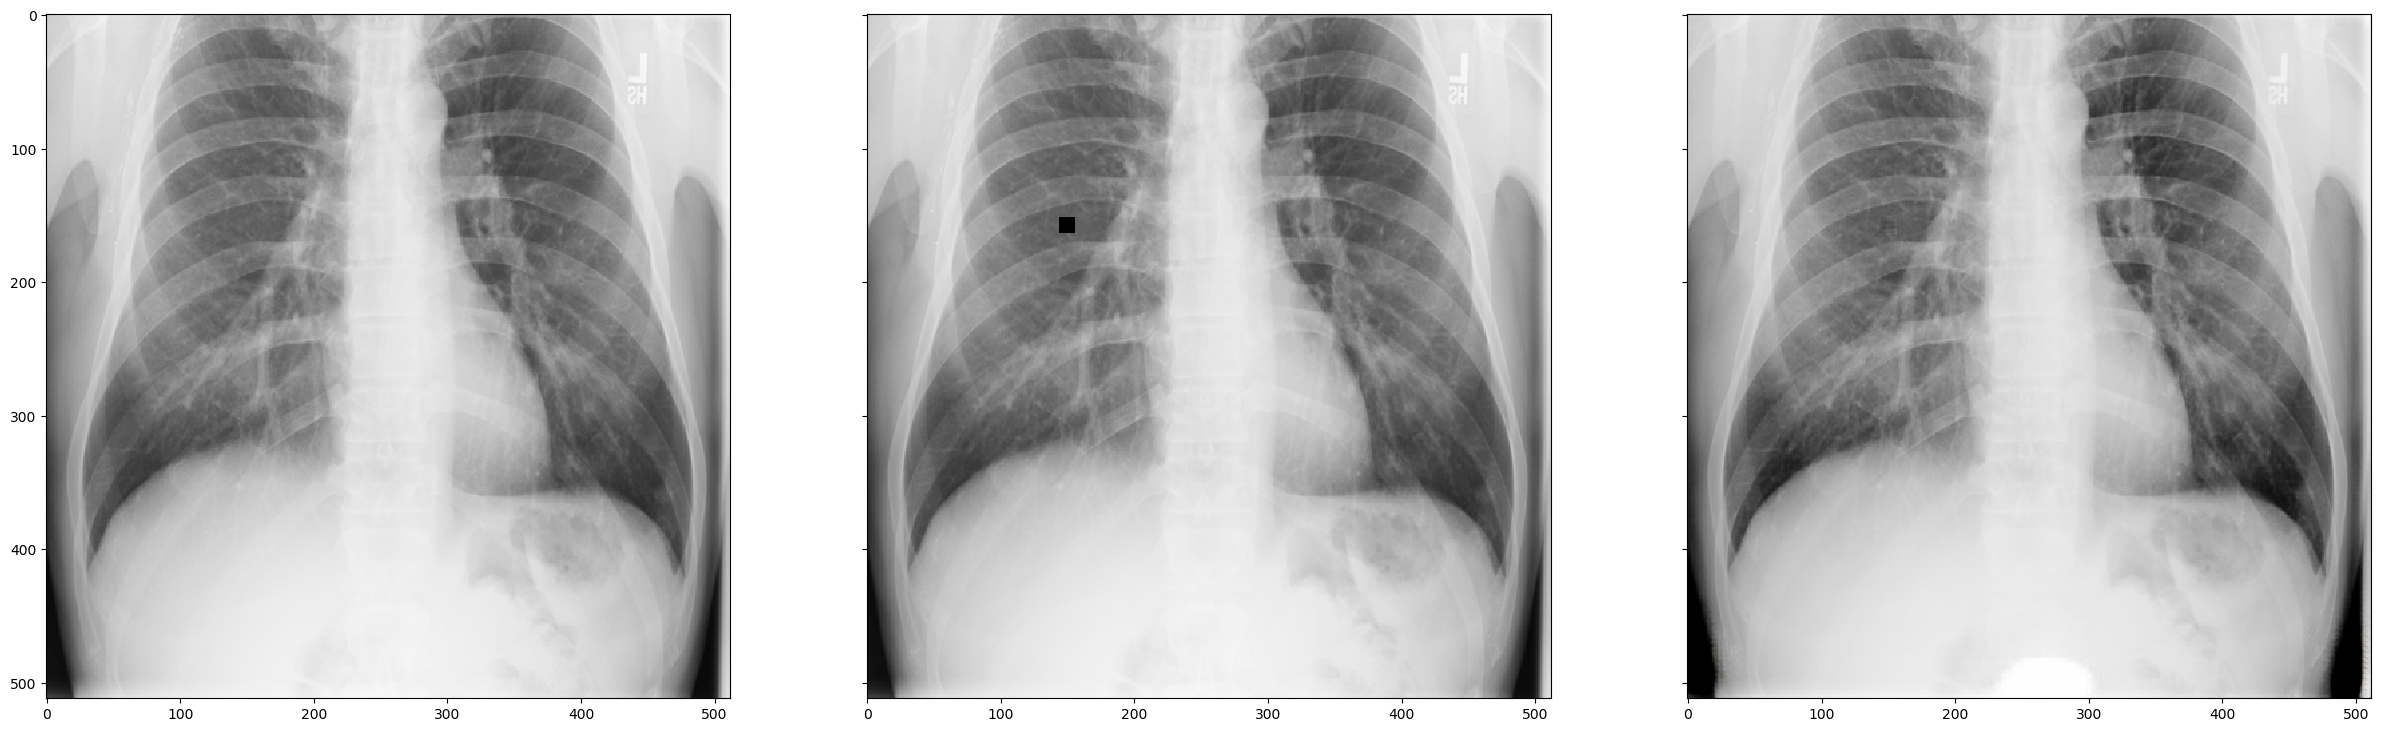

In [169]:
output = model(torch.tensor(target).unsqueeze(0))
re.show(torch.tensor(img),torch.tensor(target),torch.tensor(output).squeeze(0))

In [79]:
plt.imshow(output[0][0].detach().numpy())

In [80]:
plt.imshow(target[0])

In [81]:
plt.imshow(img[0])

In [112]:
from protocols.ae.dataset import CustomDataset as re

/home/ailab_user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


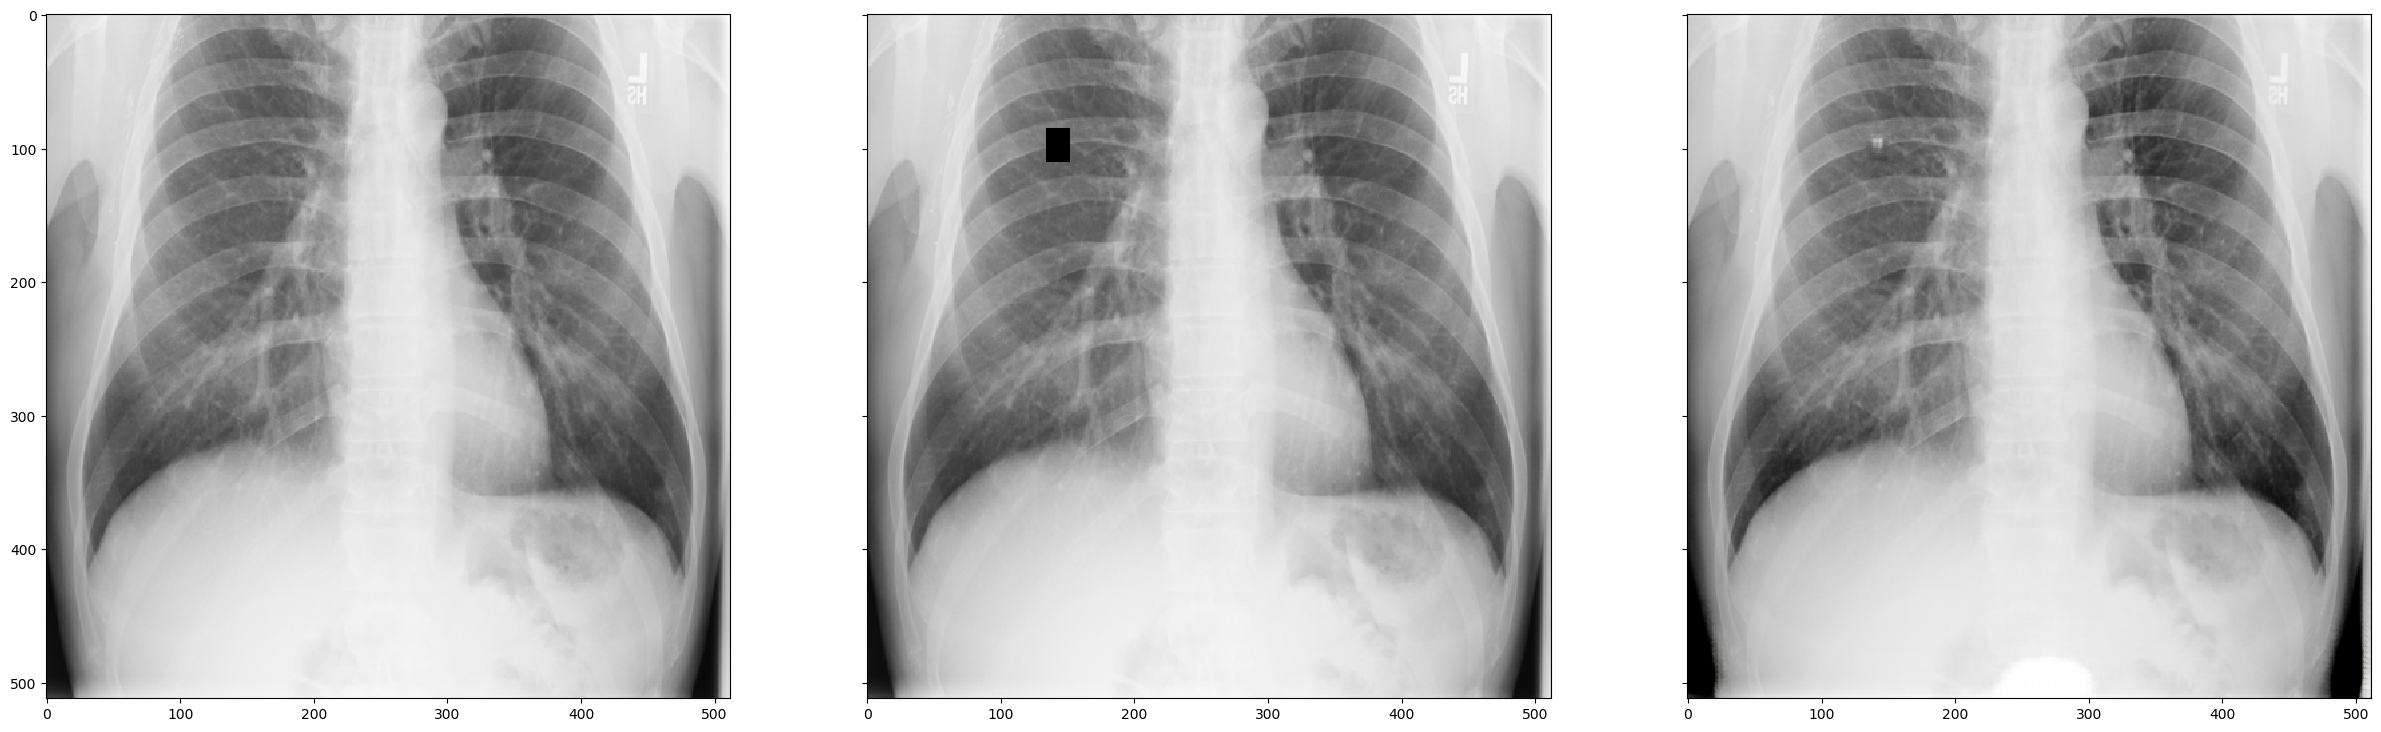

In [ ]:
output.shape

In [ ]:
img.shape

In [ ]:
target.shape